In [1]:
import numpy as np
import torch
import torchvision
import matplotlib.pyplot as plt
from time import time
from torchvision import datasets, transforms
from torch import nn, optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, random_split
from collections import OrderedDict
import time
from tqdm import tqdm
import pandas as pd 

%matplotlib inline

## Loading datasets

In [2]:
DATA_PATH = './data'

*Note:* Data augmentation with `ColorJitter`, `RandomCrop` and `RandomAffine`

`ColorJitter`: Randomly change the brightness, contrast and saturation of an image.

`RandomCrop`: Crop the given image at a random location.

`RandomAffine`: Random affine transformation of the image keeping center invariant.


In [3]:
def getTransform(target_size, isTrain=True):
    transform = [
        transforms.Resize((target_size, target_size)),
        #input always 29x29
        transforms.Pad( (29-target_size)//2 ),
        ]
    if isTrain:
        transform += [
            transforms.RandomApply([transforms.ColorJitter(
                brightness=0.4,
                contrast=0.4,
                saturation=0.4,
                hue=0.2
            )],p=0.6),
            transforms.RandomApply([transforms.RandomAffine(
                degrees=15,
                translate=(0.1, 0.1), 
                scale=(0.9, 1.1), 
                shear=0.1
            )],p=0.6),
        ]
    
    transform += [
        transforms.ToTensor(),
        transforms.Normalize((0.5, ), (0.5, )),
    ]

    transformFunction = transforms.Compose(transform)
    return transformFunction

In [4]:
def getDatasets(target_size):
    assert target_size <= 29 and target_size % 2 == 1
    trainTransform = getTransform(target_size=target_size, isTrain=True)
    full_datasets = datasets.MNIST(root=DATA_PATH, download=True, train=True, transform=trainTransform)

    torch.manual_seed(42)
    train_size = int(.8*len(full_datasets))
    valid_size = len(full_datasets)-train_size
    train_set, valid_set = random_split(full_datasets, [train_size, valid_size])

    testTransform = getTransform(target_size=target_size, isTrain=False)
    test_set = datasets.MNIST(root=DATA_PATH, download=True, train=False, transform=testTransform)

    return dict(train=train_set, valid=valid_set, test=test_set)

In [5]:
def getDataloaders(dataset):
    torch.manual_seed(42)
    dataLoaders = dict(
        train=torch.utils.data.DataLoader(dataset['train'], batch_size=256, shuffle=True),
        valid=torch.utils.data.DataLoader(dataset['valid'], batch_size=128, shuffle=False),
        test=torch.utils.data.DataLoader(dataset['test'], batch_size=32, shuffle=False),
    )
    return dataLoaders

In [6]:
dataset = getDatasets(target_size=29)
print(f"#Training: {len(dataset['train'])} \n#Valid: {len(dataset['valid'])} \n#Testing: {len(dataset['test'])}")

#Training: 48000 
#Valid: 12000 
#Testing: 10000


## Visualize the datasets

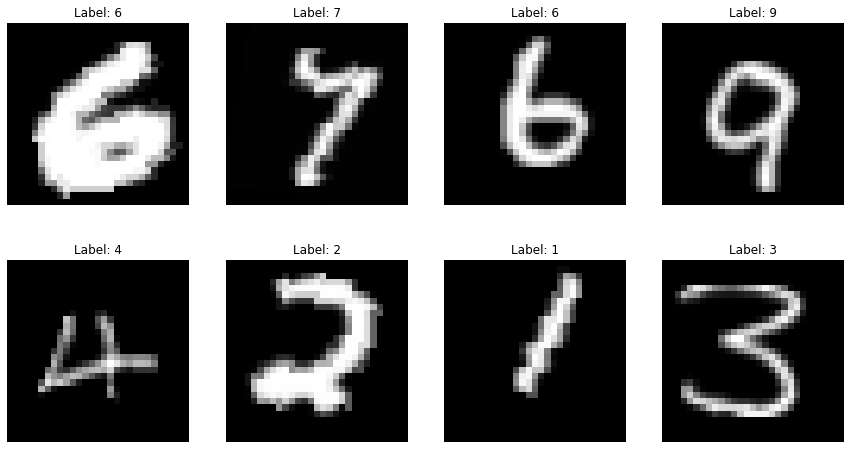

In [7]:
plt.rcParams["figure.figsize"] = [15, 8]
fig, axs = plt.subplots(2, 4)

index = 0
for i in range(2):
    for j in range(4):
        img, label = dataset['train'][index]
        axs[i][j].imshow(img.numpy().squeeze(), cmap="gray")
        axs[i][j].title.set_text(f'Label: {label}')
        axs[i][j].axis('off')
        index += 1

## Defining model

In [8]:
class MCDNN(nn.Module):
    def __init__(self):
        super(MCDNN, self).__init__()
        self.net = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=20, kernel_size=4),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),
            nn.Conv2d(in_channels=20, out_channels=40, kernel_size=5),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=3),
            nn.Flatten(),
            nn.Linear(in_features=3*3*40, out_features=150),
            nn.ReLU(),
            nn.Linear(in_features=150, out_features=10),
        )
    
    def forward(self, x):
        x = self.net(x)
        return x

In [9]:
model = MCDNN()
print(model)

MCDNN(
  (net): Sequential(
    (0): Conv2d(1, 20, kernel_size=(4, 4), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(20, 40, kernel_size=(5, 5), stride=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=3, stride=3, padding=0, dilation=1, ceil_mode=False)
    (6): Flatten(start_dim=1, end_dim=-1)
    (7): Linear(in_features=360, out_features=150, bias=True)
    (8): ReLU()
    (9): Linear(in_features=150, out_features=10, bias=True)
  )
)


### Define helper function

In [10]:
def initWeight(m):
    if type(m) == nn.Linear or type(m) == nn.Conv2d:
        nn.init.xavier_uniform_(m.weight)
        m.bias.data.fill_(0.01)


In [11]:
def saveFunction(target_size, column):
    def __save_func(model):
        model_path = f'./result/model_{target_size}_{column}.pth'
        torch.save(dict(state_dict=model.state_dict()), model_path)
        
        return f'{model_path}'
    
    return __save_func

In [12]:
def training(dataloaders, model, loss_func, optim, device="cuda:0", epochs=1, save_func=None):
    def epochTrain():
        model.train()
        #save all the epoch's loss
        total_loss = 0
        for batch_idx, (data, target) in enumerate(dataloaders['train']):
            #using cuda
            data, target = data.to(device), target.to(device)
            
            #zero the parameter gradients
            optim.zero_grad()

            #call a loss function
            pred = model(data)
            loss = loss_func(pred, target)

            #forward + backward + optimize
            loss.backward()
            optim.step()

            #print statistics
            total_loss += loss.item()
        
        epoch_loss = total_loss / len(dataloaders['train'])
        return epoch_loss
    
    def epochValid():
        model.eval()
        #save all the epoch's loss and number of error per number of evalate sample
        total_loss, total_error, total_count = 0, 0, 0
        with torch.no_grad():
            for batch_idx, (data, target) in enumerate(dataloaders['valid']):
                data, target = data.to(device), target.to(device)
 
                output = model(data)
                loss = loss_func(output, target)
                
                total_loss += loss.item()
                pred = torch.argmax(output, dim=1)
                total_error += torch.sum(pred != target).item()
                total_count += target.shape[0]

            epoch_loss = total_loss/(len(dataloaders['valid']))
            epoch_error = total_error/total_count
            return epoch_loss, epoch_error

    train_losses, valid_losses, valid_errors = [], [], []
    progess_bar = tqdm(range(epochs), total=epochs)
    best_score = 100000
    save_message = ''
    for epoch in progess_bar:
        #append current train epoch's loss score
        train_losses.append(epochTrain())
        
        #append current valid's loss and error
        valid_loss, valid_error = epochValid()
        valid_losses.append(valid_loss)
        valid_errors.append(valid_error)

        #print progess bar
        progess_bar.set_description(f'Epoch: {epoch+1} | Loss score: {valid_loss:.3f} | Current Escore: {valid_error*100:.3f}% | {save_message}')

        #Error score: the lower the better
        if valid_error < best_score:
            best_score = valid_error
            progess_bar.set_description(f'Epoch: {epoch+1} | Loss score: {valid_loss:.3f} | New best Escore: {best_score*100:.3f}% | {save_message}')
            #save the model when the current epoch have lower loss than the previous
            if save_func is not None:
                save_message = save_func(model)

    return train_losses, valid_losses, valid_errors

## Demo-training

In [17]:
dataloaders = getDataloaders(dataset)

device = f"cuda:{torch.cuda.current_device()}"
#temp train
epochs = 5
model = MCDNN().to(device)
model.apply(initWeight)
lossFunc = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model.parameters(), lr=1e-3)

#training function
train_losses, valid_losses, valid_errors = training(dataloaders=dataloaders, model=model, loss_func=lossFunc, optim=optimizer, device=device, epochs=epochs, save_func=saveFunction(29, 1))

Epoch: 5 | Loss score: 0.090 | New best Escore: 2.692% ./result/29_model_1.pth: 100%|██████████| 5/5 [04:45<00:00, 57.16s/it]


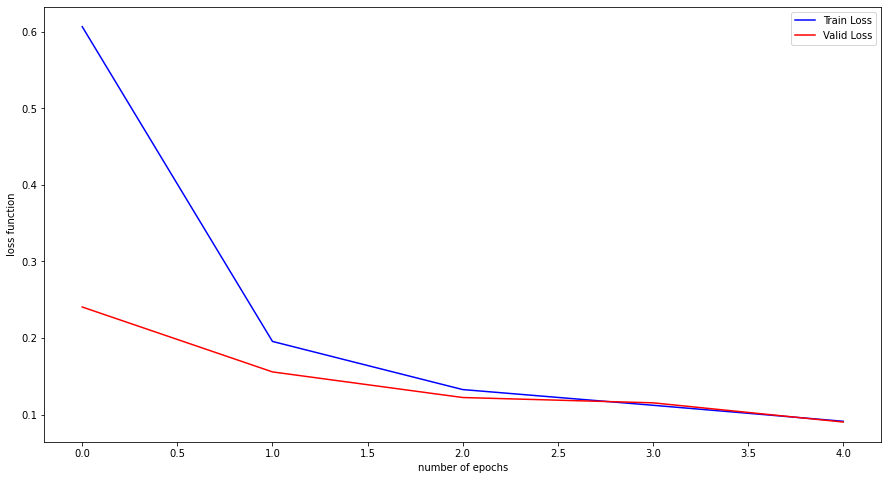

In [20]:
fig = plt.figure()
plt.plot(range(epochs), train_losses, color='blue')
plt.plot(range(epochs), valid_losses, color='red')
plt.legend(['Train Loss', 'Valid Loss'], loc='upper right')
plt.xlabel('number of epochs')
plt.ylabel('loss function')
plt.show()

## Training multi-column

"The original MNIST digits are normalized such that the width or height of the bounding box equals *`20 pixels`*. Aspect rations for various digits vary strongly and we therefore create six additional datasets by normalizing digit width to *`10, 12, 14, 16, 18, 20 pixels`*"

In [13]:
TARGET_SIZES = [11, 29, 13, 15, 17, 19, 21]

In [28]:
train_losses, valid_losses, valid_errors = [], [], []
for target_size in TARGET_SIZES:
    dataset = getDatasets(target_size=target_size)
    dataloader = getDataloaders(dataset=dataset)
    for col_index in range(5):

        device = f"cuda:{torch.cuda.current_device()}"
        epochs = 10
        model = MCDNN().to(device)
        lossFunc = nn.CrossEntropyLoss()
        optimizer = torch.optim.Adam(params=model.parameters(), lr=1e-3)

        #train
        e_train_losses, e_valid_losses, e_valid_errors = training(dataloaders=dataloader, model=model, device=device, loss_func=lossFunc, optim=optimizer, epochs=epochs, save_func=saveFunction(target_size, col_index))

    train_losses.append(e_train_losses)
    valid_losses.append(e_valid_losses)
    valid_errors.append(e_valid_errors)

Epoch: 10 | Loss score: 0.196 | New best Escore: 5.917% | ./result/model_11_0.pth: 100%|██████████| 10/10 [07:24<00:00, 44.41s/it]
Epoch: 10 | Loss score: 0.197 | New best Escore: 5.883% | ./result/model_11_1.pth: 100%|██████████| 10/10 [07:32<00:00, 45.22s/it]
Epoch: 10 | Loss score: 0.195 | New best Escore: 5.800% | ./result/model_11_2.pth: 100%|██████████| 10/10 [07:16<00:00, 43.65s/it]
Epoch: 10 | Loss score: 0.195 | New best Escore: 5.792% | ./result/model_11_3.pth: 100%|██████████| 10/10 [07:34<00:00, 45.46s/it]
Epoch: 10 | Loss score: 0.196 | New best Escore: 5.833% | ./result/model_11_4.pth: 100%|██████████| 10/10 [07:41<00:00, 46.16s/it]
Epoch: 10 | Loss score: 0.070 | Current Escore: 2.242% | ./result/model_29_0.pth: 100%|██████████| 10/10 [07:33<00:00, 45.31s/it]
Epoch: 10 | Loss score: 0.069 | Current Escore: 2.158% | ./result/model_29_1.pth: 100%|██████████| 10/10 [07:36<00:00, 45.64s/it]
Epoch: 10 | Loss score: 0.070 | Current Escore: 2.200% | ./result/model_29_2.pth: 100

## Evaluate 

In [14]:
#Load 35nn 
models = {}
device = f'cuda:{torch.cuda.current_device()}'
for target_size in TARGET_SIZES:
    for col_index in range(5):
        model_id = f'{target_size}_{col_index}'
        model_path = f'./result/model_{model_id}.pth'
        model = MCDNN().to(device)
        model.load_state_dict(torch.load(model_path)['state_dict'])
        model.eval()
        models[model_id] = model

In [15]:
def comparePrediction(pred):
    summary_pred = torch.empty(0).to(device)
    width = len(pred[1])
    
    for i in range(width):
        temp = torch.empty(0).to(device)
        for j in range(5):
            temp = torch.cat((temp, pred[j][i].view(1)))
        spred = torch.mode(temp, dim=0).values
        summary_pred = torch.cat((summary_pred, spred.view(1)))

    return summary_pred

def getAvg(arr):
    total = 0
    arrmin = 10
    for e in arr:
        total += e
        if e < arrmin:
            arrmin = e
    avg = f"{(total/len(arr)):.2f}±{(-arrmin+total/len(arr)):.2f}"
    return avg


In [16]:
def test(model, dataloaders, loss_func, device):
    model.eval()
    test_loss, test_error, test_count = 0, 0, 0

    with torch.no_grad():
        for batch_idx, (data, target) in enumerate(dataloaders['test']):
            data, target = data.to(device), target.to(device)

            output = model(data)
            loss = loss_func(output, target)
            
            pred = torch.argmax(output, dim=1)
            test_loss += loss.item()
            test_error += torch.sum(pred != target).item()
            test_count += target.shape[0]
        
    epoch_loss = test_loss/(len(dataloaders['test']))
    epoch_error = 100*test_error/test_count
    #unit: %
    
    return epoch_loss, epoch_error

def test5Columns (target_size, models, dataloaders,loss_func, device):
    test_errors, test_count = 0, 0

    with torch.no_grad():
        for batch_idx, (data, target) in enumerate(dataloaders['test']):
            #muilti predict result save here in tensor
            
            mul_pred = []
            for col_index in range(5):
                model = models[f'{target_size}_{col_index}']
                model.eval()
                data, target = data.to(device), target.to(device)

                output = model(data)
                loss = loss_func(output, target)
                pred = torch.argmax(output, dim=1)
                mul_pred.append(pred)
            
            summary_pred = comparePrediction(mul_pred).type(torch.uint8)
            test_errors += torch.sum(summary_pred != target).item()
            test_count += target.shape[0]

    error = 100*test_errors/test_count
    #unit: %
    return error


In [19]:
#table summary
summary = {
    "Trial": [1, 2, 3, 4, 5, "avg.", "5 columns MCDNN"]
}

lossFunc = nn.CrossEntropyLoss()
device = f'cuda:{torch.cuda.current_device()}'

for target_size in TARGET_SIZES:
    target_errors, target_losses = [], []
    
    #get the normalized test
    dataset = getDatasets(target_size=target_size)
    dataloader = getDataloaders(dataset=dataset)

    #get 5 columns MCDNN result
    five_col_result = test5Columns(models=models, target_size=target_size, dataloaders=dataloader, loss_func=lossFunc, device=device)

    #get individual columns result
    for col_index in range(5):
        mul_loss, mul_error = test(model=models[f'{target_size}_{col_index}'], dataloaders=dataloader, loss_func=lossFunc, device=device)
        target_errors.append(mul_error)
        target_losses.append(mul_loss)

    #get avg.
    target_errors.append(getAvg(target_errors))

    target_errors.append(five_col_result)

    summary[f"W{target_size}"] = target_errors
        

In [20]:
df = pd.DataFrame(summary)
df

,Trial,W11,W29,W13,W15,W17,W19,W21
0,1,2.58,0.94,1.95,1.5,1.18,0.97,0.85
1,2,2.52,0.93,1.97,1.53,1.22,1.03,0.86
2,3,2.55,1.0,1.98,1.54,1.19,0.91,0.94
3,4,2.57,0.99,2.01,1.55,1.2,1.04,0.82
4,5,2.53,0.99,1.97,1.49,1.21,1.02,0.96
5,avg.,2.55±0.03,0.97±0.04,1.98±0.03,1.52±0.03,1.20±0.02,0.99±0.08,0.89±0.07
6,5 columns MCDNN,2.55,0.96,1.94,1.48,1.21,0.98,0.86


In [ ]:
def testAllColumns (models, loss_func, device):
    def testSingleColumn (target_size):
        dataset = getDatasets(target_size=target_size)
        dataloader = getDataloaders(dataset=dataset)
        with torch.no_grad():
            #save all the predict of whole column in here
            merge_pred = torch.tensor([]).to(device)   
            for batch_idx, (data, target) in enumerate(dataloader['test']):
                #muilti predict result save here in tensor
                
                mul_pred = []
                for col_index in range(5):
                    model = models[f'{target_size}_{col_index}']
                    model.eval()
                    data, target = data.to(device), target.to(device)

                    output = model(data)
                    loss = loss_func(output, target)
                    pred = torch.argmax(output, dim=1)
                    mul_pred.append(pred)
                
                summary_pred = comparePrediction(mul_pred).type(torch.uint8)
                merge_pred = torch.cat((merge_pred, summary_pred))
        return merge_pred

    TARGET_SIZES = [11, 29, 13, 15, 17, 19, 21]
    all_pred = []
    test_error, test_count = 0, len(dataset['test'])
    
    for target_size in TARGET_SIZES:
        all_pred.append(testSingleColumn(target_size=target_size))
    summary_pred = comparePrediction(all_pred).type(torch.uint8)
    
    target = torch.tensor([]).to(device)
    for i in range(len(dataset['test'])):
        target = torch.cat((target, torch.Tensor([dataset['test'][i][1]]).to(device))).type(torch.uint8)
    test_error += torch.sum(summary_pred != target).item()
    
    return test_error/len(target)


device = f"cuda:{torch.cuda.current_device()}"
lossFunc = nn.CrossEntropyLoss()
all_columns_error = testAllColumns(models, loss_func=lossFunc, device=device)

In [53]:
print("35-net MCDNN [%]:", all_columns_error*100)

35-net MCDNN [%]: 1.27
